In [3]:
from spectral_cube import SpectralCube as sc
from astropy import units as u
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy import wcs
import matplotlib 
from scipy.optimize import curve_fit
from pvextractor import extract_pv_slice, Path
import copy
import re
import pandas as pd
import os 


In [4]:
def rest2measfreq(restfreq, vlsr):
    rest = restfreq*u.MHz         # restfreq in MHz   vlsr in km/s
    radio_equiv = u.doppler_radio(rest)
    vel = vlsr*u.km/u.s
    shiftfreq = vel.to(u.MHz, equivalencies=radio_equiv)  # shiftfreq in MHz
    return shiftfreq 



In [5]:
contfile_list = './TM1cont_filelist.txt'
cubefile_list = './TM1cube_filelist.txt'

f = open(contfile_list, 'r')
contfiles = f.readlines()
f.close()
contfiles = [s.rstrip('\n') for s in contfiles]


f = open(cubefile_list, 'r')
cubefiles = f.readlines()
f.close()
cubefiles = [s.rstrip('\n') for s in cubefiles]

# pattern = r'I\d{5}[-+p]\d{4}'
# sources = [re.findall(pattern, s)[0] for s in contfiles]
# sources_ptoplus = [s.replace('p', '+') for s in sources]

source_info = np.genfromtxt('./sourcetable.csv', comments='#',dtype=None, delimiter=',')

source = 'I17589-2312'
source_info_cell = next((c for c in source_info if c[1] == source.encode('utf-8')), None)
vlsr = source_info_cell[7]
contfile = [string for string in contfiles if source in string][0]  # find the fits file
cubefile = [string for string in cubefiles if source in string][0]


if not os.path.exists('./%s'%source):
    os.makedirs('./%s'%source)



/tmp/ipykernel_2453267/720211844.py:19: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  source_info = np.genfromtxt('./sourcetable.csv', comments='#',dtype=None, delimiter=',')


/home/mxf/.conda/envs/scousepy/lib/python3.12/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


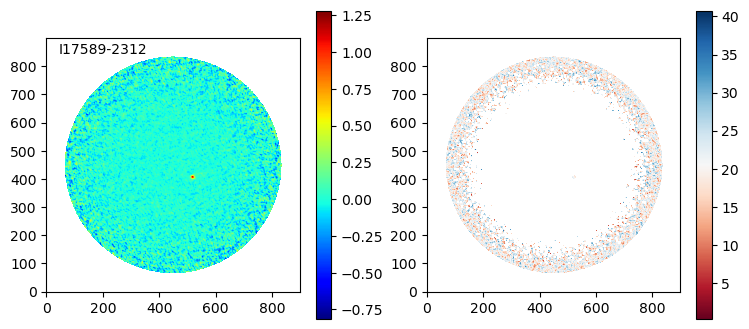

In [16]:
cube = sc.read(cubefile).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                        rest_value=220.7090165*u.GHz)
rms = np.std(cube.subcube(250,650,250,650,0,1)[0,:,:])*1.2  # mxf: take a center box of the first channel to compute the noise... any better solution for this?
ch3cn_cube = cube.spectral_slab((vlsr-20)*u.km/u.s, (vlsr+20)*u.km/u.s)
# ch3ch_cubeinK = ch3cn_cube.to(u.K)
ch3cn_cube_masked = ch3cn_cube.with_mask(ch3cn_cube > 3*rms)

mom0 = ch3cn_cube.moment0()
mom1 = ch3cn_cube_masked.moment1()
# mom0.write('./%s/%s_CH3CN_mom0.fits'%(source, source), overwrite=True)
# mom1.write('./%s/%s_CH3CN_mom1.fits'%(source, source), overwrite=True)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(mom0.array,origin='lower', cmap='jet')
plt.text(0.05,0.94, source,transform=plt.gca().transAxes)
plt.colorbar()
plt.subplot(122)
plt.imshow(mom1.array,origin='lower',cmap='RdBu')
plt.colorbar()


In [29]:
rms

<Slice 0.00625251 Jy / beam>

(383.0, 433.0)

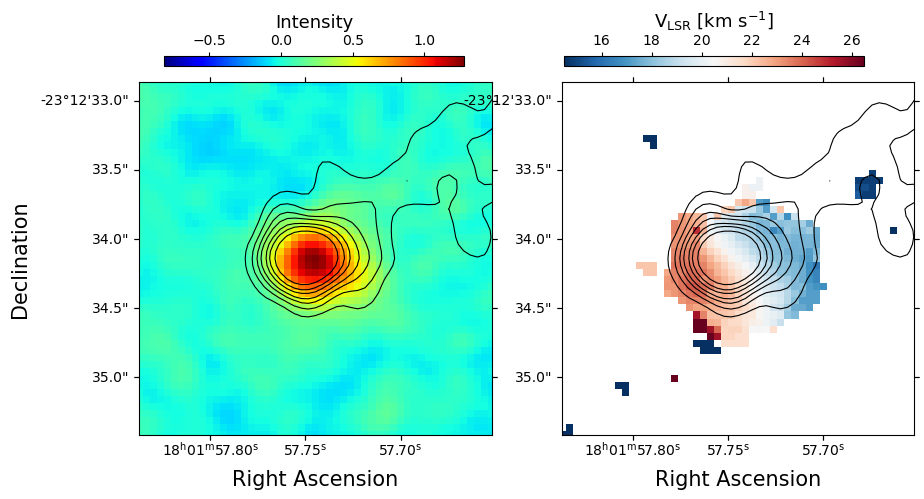

In [8]:
cont_hdu = fits.open(contfile)[0]
cont_wcs = wcs.WCS(cont_hdu.header, naxis=2)
cont_image = np.squeeze(cont_hdu.data)
cont_rms = 3e-4
cont_levels = np.array([3,5,7,9,12,15,20,50,100])
hdul = fits.HDUList([cont_hdu])
cont_hdu.writeto('./%s/%s_cont.fits'%(source, source), overwrite=True)  
################################################################################

mom0fitspath = './%s/%s_CH3CN_mom0.fits'%(source, source)
hdu1 = fits.open(mom0fitspath)[0]
wcs1 = wcs.WCS(hdu1.header, naxis=2)
image1 = np.squeeze(hdu1.data)

mom1fitspath = './%s/%s_CH3CN_mom1.fits'%(source, source)
hdu2 = fits.open(mom1fitspath)[0]
wcs2 = wcs.WCS(hdu2.header, naxis=2)
image2 = np.squeeze(hdu2.data)

################################################################################
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,2,1, projection=wcs1)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im = ax.imshow(image1, origin='lower', cmap='jet')
ax.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='k', linewidths=0.8)
ax.set_xlabel('Right Ascension', fontsize=15)
ax.set_ylabel('Declination', fontsize=15)
ax.tick_params(labelsize = 10)


rect = [0.15, 0.88, 0.3, 0.02] 
cax = fig.add_axes(rect)
cb = fig.colorbar(im, orientation='horizontal',cax=cax)
cb.ax.tick_params(direction='out', top=True, bottom=False)
cb.set_label(r'Intensity', fontsize=13, loc='center')
cb.ax.xaxis.set_label_position('top')
cb.ax.tick_params(axis='x',labelbottom=False, length=0)
cb.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

################################################################################
vmin, vmax = vlsr-6, vlsr+6
ax1 = plt.subplot(1,2,2, projection=wcs1)
im1 = ax1.imshow(image2, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('Right Ascension', fontsize=15)
ax1.set_ylabel(' ', fontsize=15)
ax1.tick_params(labelsize = 10)


rect1 = [0.55, 0.88, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

peaky, peakx = np.unravel_index(np.argmax(np.nan_to_num(image1)), image1.shape)
xl, xr = peakx-25, peakx+25
yd, yu = peaky-25, peaky+25
ax.set_xlim([xl,xr])
ax.set_ylim([yd,yu])
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

# plt.savefig('./%s/%s_CH3CN_mom01.pdf'%(source, source), dpi=300, bbox_inches='tight')

# Position - Velocity(Frequency) Diagram

In [9]:
# ch3cn_cube = sc.read('I18134_CH3CN.fits')
# ch3cn_cube = ch3cn_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
# ch3cn_cube = sc.read('I18134_spw1.fits')

mom1fitspath = './%s/%s_CH3CN_mom1.fits'%(source, source)
mom1_hdu = fits.open(mom1fitspath)[0]
mom1_wcs = wcs.WCS(mom1_hdu.header, naxis=2)
mom1_image = np.squeeze(mom1_hdu.data)

start_end = [(499, 394), (541, 419)]
path = Path(start_end, width=5)
pv = extract_pv_slice(cube=ch3cn_cube, path=path)
# pv.writeto('./%s/%s_CH3CN_pv.fits'%(source, source))


/home/mxf/.conda/envs/scousepy/lib/python3.12/site-packages/pvextractor/geometry/path.py:262: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.append(MPLPolygon(list(zip(poly.x, poly.y)), **kwargs))


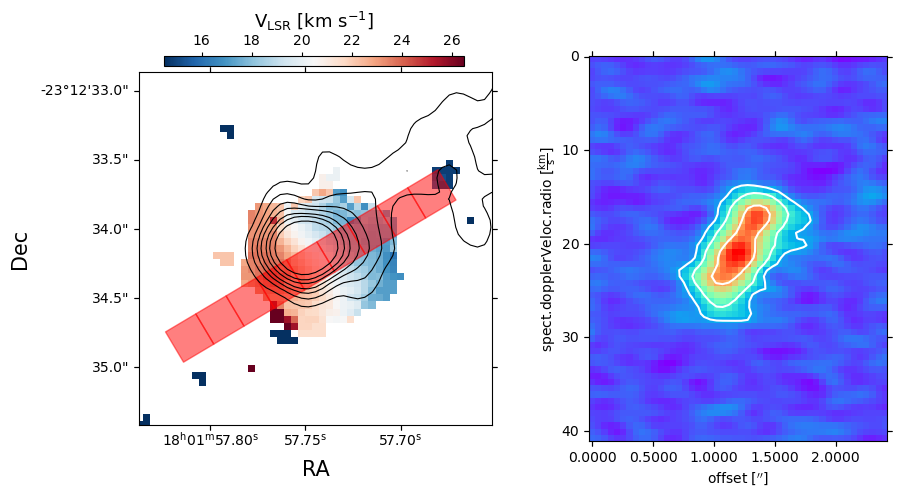

In [10]:
fig = plt.figure(figsize=[10,5])

### Plot Mom_1
ax1 = plt.subplot(121, projection=mom1_wcs)
# ax.imshow(image1, origin='lower', vmin=1e-1, vmax=4e-1)
im1 = ax1.imshow(mom1_image, origin='lower', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.contour(cont_image, levels = cont_levels*cont_rms, zorder=2, colors='black', linewidths=0.8)
ax1.set_xlabel('RA', fontsize=15)
ax1.set_ylabel('Dec', fontsize=15)
ax1.tick_params(labelsize = 10)

rect1 = [0.15, 0.86, 0.3, 0.02] 
cax1 = fig.add_axes(rect1)
cb1 = fig.colorbar(im1, orientation='horizontal',cax=cax1)
cb1.ax.tick_params(direction='out', top=True, bottom=False)
cb1.set_label(r'V$_{\rm LSR}$ [km s$^{-1}$]', fontsize=13, loc='center')
cb1.ax.xaxis.set_label_position('top')
cb1.ax.tick_params(axis='x',labelbottom=False, length=0)
cb1.ax.tick_params(axis='x',labeltop=True, top=True, length=3)

# xl, xr = 500, 600
# yd, yu = 300, 400
ax1.set_xlim([xl,xr])
ax1.set_ylim([yd,yu])

path.show_on_axis(ax1, spacing=5, color='r', alpha=0.5)

### Plot Position - Velocity Diagram
rms_ref = rms
pv_levels = np.array([3,7,15, 22,30])

w_pv = wcs.WCS(pv.header)
ax2 = plt.subplot(122, projection=w_pv)
im2 = ax2.imshow(pv.data, cmap='rainbow')
ax2.contour(pv.data, levels=pv_levels*rms_ref, colors='w')

ax2.set_aspect(1)
ax2_x = ax2.coords[0]
ax2_x.set_format_unit(u.arcsec)
ax2_y = ax2.coords[1]
ax2_y.set_format_unit(u.km/u.s)

# plt.savefig('./%s/%s_CH3CN_pv.pdf'%(source, source), dpi=300, bbox_inches='tight')

In [11]:
ch3cn_cube = sc.read(cubefile)
# ch3cn_cube = ch3cn_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
ch3cn_cube = ch3cn_cube.with_spectral_unit(u.GHz, velocity_convention='radio')
# ch3cn_cube = sc.read('I18134_spw1.fits')

path = Path(start_end, width=5)
pv_spw1 = extract_pv_slice(cube=ch3cn_cube, path=path)
# pv_spw1.writeto('./%s/%s_pf.fits'%(source, source))




In [12]:
linefreq = {
            'C18O': 219560.3541, # MHz
            'HNCO': 219737.193,
            'HNCO*': 219798.32,
            'SO' : 219949.442, 
            'CH3OH': 220078.561,   # CH3OH vt=0-2
            '13CO': 220398.6765
}   

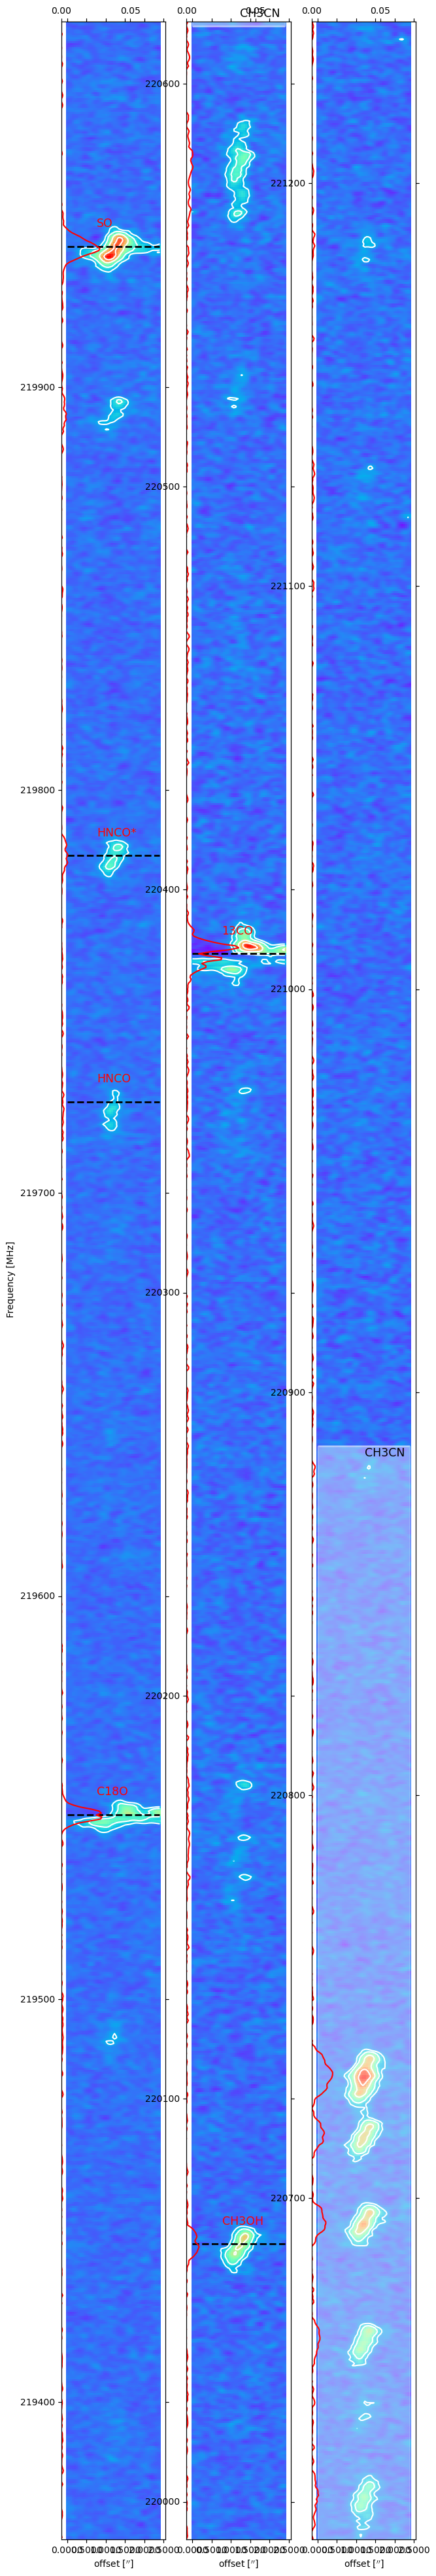

In [13]:
peakx, peaky = np.unravel_index(np.argmax(np.nan_to_num(image1)), image1.shape)
meanspec = cube[:, peakx-20:peakx+20, peaky-20:peaky+20].mean(axis=(1,2))
chanrange = np.arange(1,len(meanspec)+1)

pvfile = './%s/%s_pf.fits'%(source, source)
pv_spw1= fits.open(pvfile)[0]

rms_ref = rms
pv_levels = np.array([3,7,15, 22,30])
w_pvspw1 = wcs.WCS(pv_spw1.header)

fig_pf = plt.figure(figsize=[7,50])
ax_list = []

ax_p1 = fig_pf.add_subplot(131, projection=w_pvspw1)
ax_list.append(copy.copy(ax_p1))
im_p1 = ax_p1.imshow(pv_spw1.data, cmap='rainbow')
ax_p1.contour(pv_spw1.data, levels=pv_levels*rms_ref, colors='w')
ax_p1_x = ax_p1.coords[0]
ax_p1_x.set_format_unit(u.arcsec)
ax_p1_y = ax_p1.coords[1]
ax_p1_y.set_format_unit(u.MHz)

ax2_p1 = ax_p1.twiny()
ax2_p1.plot(meanspec.value, chanrange,'r')


ax_p2 = fig_pf.add_subplot(132, projection=w_pvspw1)
ax_list.append(copy.copy(ax_p2))
im_p2 = ax_p2.imshow(pv_spw1.data, cmap='rainbow')
ax_p2.contour(pv_spw1.data, levels=pv_levels*rms_ref, colors='w')
ax_p2_x = ax_p2.coords[0]
ax_p2_x.set_format_unit(u.arcsec)
ax_p2_y = ax_p2.coords[1]
ax_p2_y.set_format_unit(u.MHz)

ax2_p2 = ax_p2.twiny()
ax2_p2.plot(meanspec.value, chanrange,'r')

ax_p3 = fig_pf.add_subplot(133, projection=w_pvspw1)
ax_list.append(copy.copy(ax_p3))
im_p3 = ax_p3.imshow(pv_spw1.data, cmap='rainbow')
ax_p3.contour(pv_spw1.data, levels=pv_levels*rms_ref, colors='w')
ax_p3_x = ax_p3.coords[0]
ax_p3_x.set_format_unit(u.arcsec)
ax_p3_y = ax_p3.coords[1]
ax_p3_y.set_format_unit(u.MHz)

ax2_p3 = ax_p3.twiny()
ax2_p3.plot(meanspec.value, chanrange,'r')


chans = pv_spw1.header['NAXIS2']
freqrange = np.linspace(0, chans, 4)
ax_p1.set_ylim(freqrange[0:2])
ax_p2.set_ylim(freqrange[1:3])
ax_p3.set_ylim(freqrange[2:4])

ax2_p1.set_xlim(0, np.max(meanspec.value)*2)
ax2_p2.set_xlim(0, np.max(meanspec.value)*2)
ax2_p3.set_xlim(0, np.max(meanspec.value)*2)

aspect = 1
ax_p1.set_aspect(aspect)
ax_p2.set_aspect(aspect)
ax_p3.set_aspect(aspect)

ax_p1.set_ylabel(' Frequency [MHz]')
ax_p2.set_ylabel(' ')
ax_p3.set_ylabel(' ')


crval = pv_spw1.header['CRVAL2']
fdelt = pv_spw1.header['CDELT2']
naxis = pv_spw1.header['NAXIS1']
for key in linefreq:
    line_restfreq = linefreq[key] # MHz, value without unit
    line_shiftfreq = (rest2measfreq(line_restfreq, vlsr)).to(u.Hz).value
    line_y = (line_shiftfreq-crval)/fdelt + 1
    ax_id = np.sum(line_y > freqrange)-1
    ax_list[ax_id].hlines(y=line_y, xmin=0, xmax=pv_spw1.header['NAXIS1']-1, linestyles='--', colors='k', linewidth=2)
    ax_list[ax_id].text(15, line_y+10, '%s'%key, size=12.5, color='r')

ch3cn_range = [rest2measfreq(220641.0839, vlsr), rest2measfreq(220889.1237, vlsr)]
ch3cn_range_d = (ch3cn_range[0].to(u.Hz).value - crval)/fdelt + 1 - 25
ch3cn_range_u = (ch3cn_range[1].to(u.Hz).value - crval)/fdelt + 1 + 25

ax_p2.fill_between(np.arange(0, naxis),ch3cn_range_d, ch3cn_range_u, alpha=0.4, color='w')
ax_p3.fill_between(np.arange(0, naxis),ch3cn_range_d, ch3cn_range_u, alpha=0.4, color='w')
ax_p2.text(naxis/2, ch3cn_range_d+5, 'CH3CN', size=12.5, color='k')
ax_p3.text(naxis/2, ch3cn_range_u-5, 'CH3CN', size=12.5, color='k')


# plt.savefig('./I17589_PF.pdf', dpi=300, bbox_inches='tight')

In [25]:
cube

SpectralCube with shape=(3838, 900, 900) and unit=Jy / beam:
 n_x:    900  type_x: RA---SIN  unit_x: deg    range:   270.484745 deg:  270.498603 deg
 n_y:    900  type_y: DEC--SIN  unit_y: deg    range:   -23.215264 deg:  -23.202528 deg
 n_s:   3838  type_s: VRAD      unit_s: km / s  range:     -720.720 km / s:    1824.272 km / s

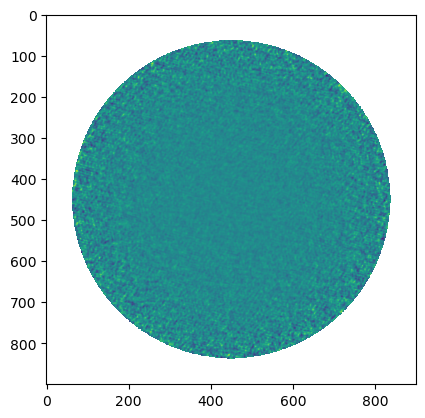

In [28]:
cube[300,:,:].quicklook()